# Orbit Error Prediction using Support Vector Machines


## Introduction

Low earth orbit (LEO) is a crowded place and the number of anthropogenic space objects (ASOs) entering LEO is rapidly escalating. With this population boom also comes the inevitable increase in close encounters (conjunctions) between objects. The heart of the space situational awareness (SSA) problem is to predict where ASOs are now and where they are going to be in the future. This includes objects from the size of a spec of paint to the International Space Station. Current state-of-the-art models for performing orbit propagation tend to be physics based [Kalman filters](https://en.wikipedia.org/wiki/Kalman_filter) and variants like the [extended Kalman filter](https://en.wikipedia.org/wiki/Extended_Kalman_filter) and the [unscented Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter#Unscented_Kalman_filter). These modeling techniques are robust to handling uncertainty in both the data, i.e. where the object currently is in orbit, and the underlying physical model. The goal of the IBM Space Tech team's [SSA project](https://github.com/ibm/spacetech-ssa) is to try and use machine learning techniques to estimate the error in these orbit propagation models to better improve their predictive power. An overview of the flow of our process can be seen here



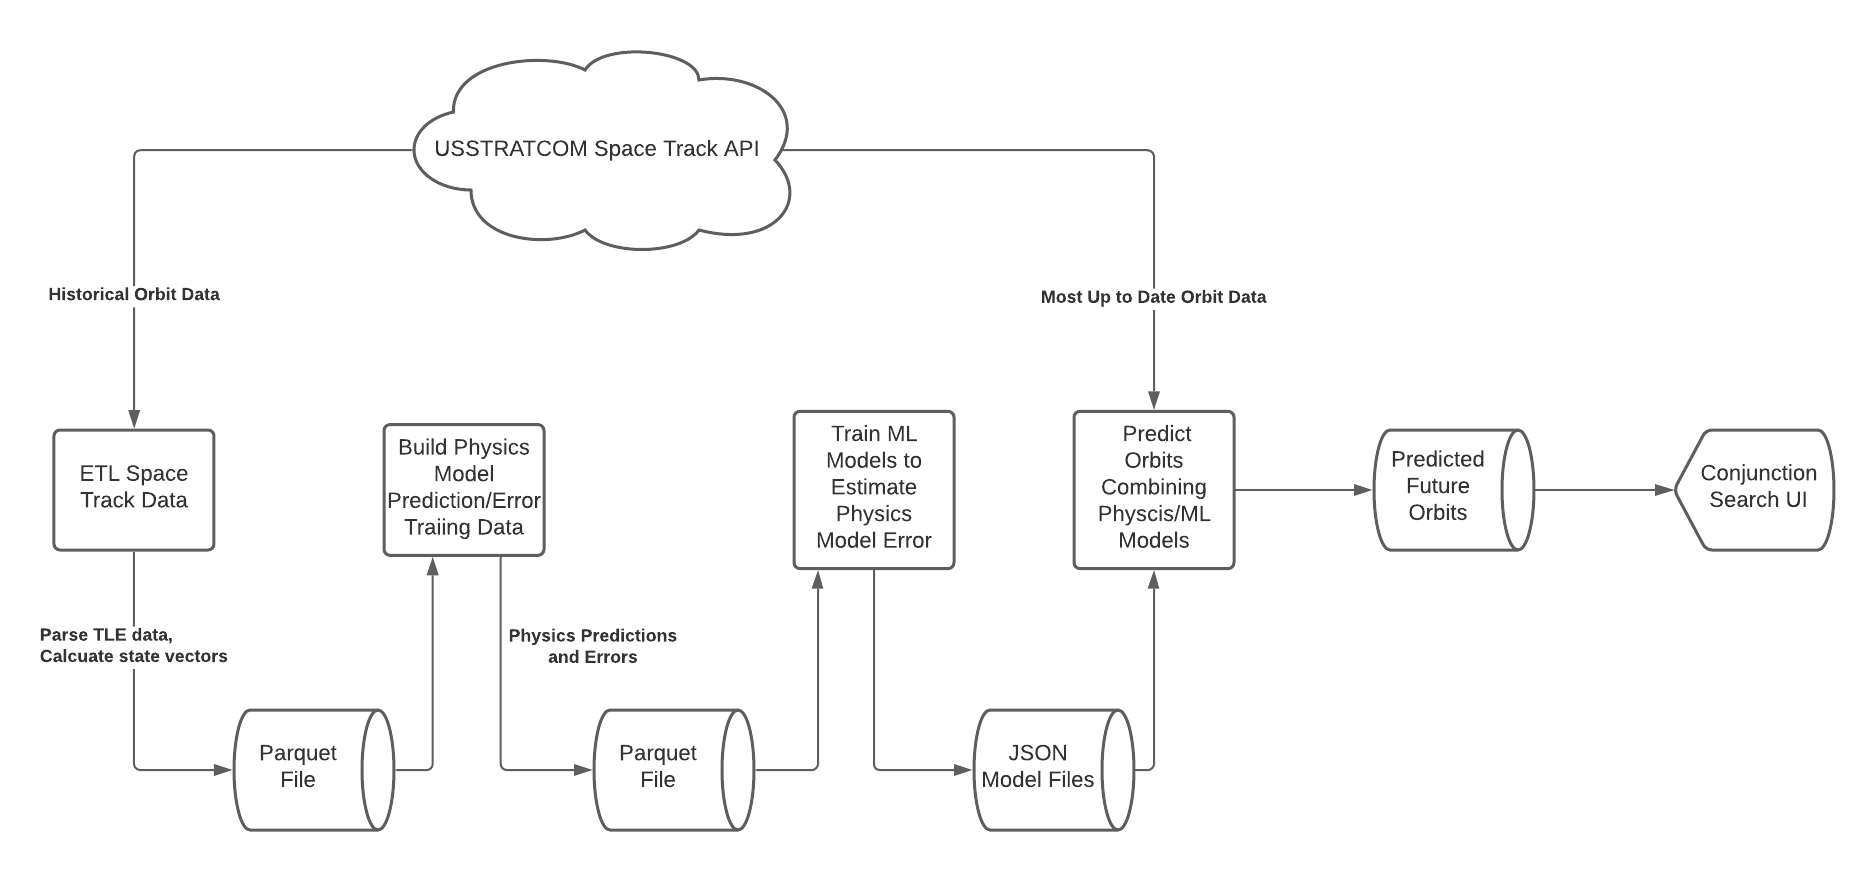

## Dependencies

First we need to install the [orbit prediction package](https://github.com/IBM/spacetech-ssa/tree/master/orbit_prediction) from the [SSA project](https://github.com/ibm/spacetech-ssa) that will allow us to work with satellite orbit data.

In [ ]:
!pip install -e git+https://github.com/IBM/spacetech-ssa.git#egg=orbit_prediction\&subdirectory=orbit_prediction
!pip install scikit-learn

## Getting TLE Data

[Two-line element set (TLE)](https://en.wikipedia.org/wiki/Two-line_element_set) is a data format that specifies the orbit of an object around the Earth at a particular point in time. The U.S. government provides an API for downloading TLE data and you can sign up for an account [here](https://www.space-track.org/auth/login) if you want to execute this notebook. You should enter your account credentials in the cell below. For the purposes of this demo we will

In [1]:
SPACETRACK_USERNAME=''
SPACETRACK_PASSWORD=''

Next we will use the SpaceTrack API to download orbit data for the International Space Station (ISS) for the past 30 days. First we import the module that will allow us to ETL the SpaceTrack TLE data.

In [2]:
import orbit_prediction.spacetrack_etl as etl

Next we create a SpaceTrack API client. The SpaceTrack API is heavily rate limited and this client will keep us compliant with the terms of use.

In [3]:
spacetrack_client = etl.build_space_track_client(SPACETRACK_USERNAME,
                                                 SPACETRACK_PASSWORD)

We then create an instance that knows how to ETL the raw TLE data into a [pandas](https://pandas.pydata.org) [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [4]:
spacetrack_etl = etl.SpaceTrackETL(spacetrack_client)

Finally we fetch the raw TLE data and do the ETL. Every satellite in orbit has a [NORAD ID](https://en.wikipedia.org/wiki/Satellite_Catalog_Number) associated with it and the ID for the ISS is `25544`.

In [5]:
iss_orbit_data = spacetrack_etl.build_leo_df(norad_ids=['25544'],
                                             last_n_days=30,
                                             only_latest=None)

INFO:orbit_prediction.spacetrack_etl:Fetching Satellite Catalog Data...
INFO:orbit_prediction.spacetrack_etl:Number of TLE Batch Requests: 1
INFO:orbit_prediction.spacetrack_etl:Starting to fetch TLEs from space-track.org
INFO:orbit_prediction.spacetrack_etl:Processing batch 1/1
INFO:orbit_prediction.spacetrack_etl:Fetching TLEs for 1 ASOs...
INFO:orbit_prediction.spacetrack_etl:Parsing raw TLE data...
INFO:orbit_prediction.spacetrack_etl:Finished fetching TLEs
INFO:orbit_prediction.spacetrack_etl:Calculating orbital state vectors for 161 TLEs...


Lets take a look at the resulting DataFrame. Each line corresponds to a given observation of the ISS from the ground. Each observation consists of a timestamp the observation was made called the `epoch` and two 3-dimensional real valued vectors, **r** and **v**,

\begin{equation*}
  \mathbf{r} =
  \begin{pmatrix}
    r_{x}\\
    r_{y}\\
    r_{z}\\
  \end{pmatrix}
  \mathbf{v} =
  \begin{pmatrix}
    v_{x}\\
    v_{y}\\
    v_{z}\\
  \end{pmatrix}
\end{equation*}

corresponding to the position and velocity of the object respectively.

In [6]:
iss_orbit_data

,aso_name,aso_id,epoch,r_x,r_y,r_z,v_x,v_y,v_z,object_type
0,ISS (ZARYA),25544,2021-02-14 17:05:30.961824,2.857638e+06,-3.122249e+06,5.318749e+06,5297.447610,5516.077305,394.566851,payload
1,ISS (ZARYA),25544,2021-02-14 21:59:56.420736,5.547009e+06,2.661402e+06,2.894225e+06,-131.456276,5760.371080,-5041.280532,payload
2,ISS (ZARYA),25544,2021-02-14 23:20:27.312576,3.788700e+06,-2.038313e+06,5.263041e+06,4584.333815,6059.698310,-950.475628,payload
3,ISS (ZARYA),25544,2021-02-15 05:50:32.015904,5.163753e+06,4.337955e+06,8.667755e+05,-2497.321012,4157.703031,-5923.236896,payload
4,ISS (ZARYA),25544,2021-02-15 11:29:07.156319,-1.542274e+06,-5.547220e+06,3.610901e+06,6147.240939,1165.571905,4417.840420,payload
...,...,...,...,...,...,...,...,...,...,...
156,ISS (ZARYA),25544,2021-03-15 19:00:13.000032,1.130359e+06,6.674078e+06,-6.373881e+05,-4611.685014,1348.111213,5960.862631,payload
157,ISS (ZARYA),25544,2021-03-16 03:14:51.467424,-4.219930e+06,-1.799571e+06,5.013652e+06,715.714043,-7349.614404,-2035.729555,payload
158,ISS (ZARYA),25544,2021-03-16 04:44:35.805696,-4.260377e+06,-3.479541e+05,5.283187e+06,-353.402632,-7611.015525,-787.113134,payload
159,ISS (ZARYA),25544,2021-03-16 11:02:23.389152,-4.090332e+06,-2.961620e+06,4.547630e+06,1467.199315,-6834.926459,-3131.197031,payload


A detailed description of every column is here:

| Field        | Description                                         | Type     |
|:--- |:--- |:--- |
| aso\_id      | The unique ID for the ASO                           | string   |
| aso\_name    | The name of the ASO                                 | string   |
| epoch        | The timestamp the orbital observation was taken     | datetime |
| r\_x         | The \`x\` component of the position vector \`r\`    | float    |
| r\_y         | The \`y\` component of the position vector \`r\`    | float    |
| r\_z         | The \`z\` component of the position vector \`r\`    | float    |
| v\_x         | The \`x\` component of the velocity vector \`v\`    | float    |
| v\_y         | The \`y\` component of the velocity vector \`v\`    | float    |
| v\_z         | The \`z\` component of the velocity vector \`v\`    | float    |
| object\_type | Whether the ASO is a paylod, rocket body, or debris | string   |


## Building an ML Training Data Set

In this section we use the ISS orbit data from the last section to build a training data set for our machine learning models. We do this by using a physics-based orbital mechanics model to predict where it thinks the ISS will be for the observations that are 3 days in advance of a given row of our dataset. We can then compare where the ISS actually was based on the radar data and where the physics model says the ISS should have been. This value will be the error in the orbital mechanics model. More precisely:

An orbit prediction model $M_{\mathbf{r}_{t}, \mathbf{v}_{t}}$ is parameterized by $\mathbf{r}$ and $\mathbf{v}$ at a given time $t$ and is a function of time such that

\begin{equation*}
    M_{\mathbf{r}_{t}, \mathbf{v}_{t}}(s)
    =
    \hat{\mathbf{r}}_{t+s},
    \hat{\mathbf{v}}_{t+s}
\end{equation*}

For each observation say $\text{obs}_{t} = \left(\text{epoch}_{t}, \mathbf{r}_{t}, \mathbf{v}_{t}\right)$ we find all the other observations for that same object that are within some time threshold (i.e 3 days), call them $\text{obs}_{t+1}, \text{obs}_{t+2}, \ldots$. We then instantiate our physical model $M_{r_{t}, v_{t}}$ and use it to predict the state vectors of the future observations, i.e.

\begin{equation*}
  \hat{\mathbf{r}}_{t+1}, \hat{\mathbf{v}}_{t+1}
  =
  M_{r_{t}, v_{t}}\left(epoch_{t+1} - epoch_t\right)
\end{equation*}

We then calculate the error between the future observation and the predicted state

\begin{align*}
    \mathbf{e}_{r_{t+1}} &= \hat{\mathbf{r}}_{t+1} - \mathbf{r}_{t+1} \\
    \mathbf{e}_{v_{t+1}} &= \hat{\mathbf{v}}_{t+1} - \mathbf{v}_{t+1}
\end{align*}

In [7]:
import orbit_prediction.build_training_data as training

This function uses a physics model to predict where the ISS will be based on the radar data.

In [8]:
physics_model_predicted_orbits = training.predict_orbits(iss_orbit_data,
                                                         last_n_days=None,
                                                         n_pred_days=3)

100%|██████████| 11/11 [00:00<00:00, 853.18it/s]


It added the following columns to our DataFrame:

| Field               | Description                                                                   | Type     |
|:--- |:--- |:--- |
| start\_epoch        | The \`epoch\` when the prediction was started                                 | datetime |
| start\_r\_x         | The \`x\` component of the position vector \`r\` where the prediction started | float    |
| start\_r\_y         | The \`y\` component of the position vector \`r\` where the prediction started | float    |
| start\_r\_z         | The \`z\` component of the position vector \`r\` where the prediction started | float    |
| start\_v\_x         | The \`x\` component of the velocity vector \`v\` where the prediction started | float    |
| start\_v\_y         | The \`y\` component of the velocity vector \`v\` where the prediction started | float    |
| start\_v\_z         | The \`z\` component of the velocity vector \`v\` where the prediction started | float    |
| elapsed\_seconds    | The number of seconds between the \`start\_epoch\` and \`epoch\`              | float    |
| physics\_pred\_r\_x | The \`x\` component of the predicted position vector \`r\`                    | float    |
| physics\_pred\_r\_y | The \`y\` component of the predicted position vector \`r\`                    | float    |
| physics\_pred\_r\_z | The \`z\` component of the predicted position vector \`r\`                    | float    |
| physics\_pred\_v\_x | The \`x\` component of the predicted velocity vector \`v\`                    | float    |
| physics\_pred\_v\_y | The \`y\` component of the predicted velocity vector \`v\`                    | float    |
| physics\_pred\_v\_z | The \`z\` component of the predicted velocity vector \`v\`                    | float    |

In the final part of this section, we calculate the error in the physical model.

In [9]:
physics_model_errors = training.calc_physics_error(physics_model_predicted_orbits)

Which adds the following to our training data:

| Field              | Description                                                        | Type  |
|------------------ |------------------------------------------------------------------ |----- |
| physics\_err\_r\_x | The prediction error in the \`x\` component of the position vector | float |
| physics\_err\_r\_y | The prediction error in the \`y\` component of the position vector | float |
| physics\_err\_r\_z | The prediction error in the \`z\` component of the position vector | float |
| physics\_err\_v\_x | The prediction error in the \`x\` component of the velocity vector | float |
| physics\_err\_v\_y | The prediction error in the \`y\` component of the velocity vector | float |
| physics\_err\_v\_z | The prediction error in the \`z\` component of the velocity vector | float |


Thus a row in the feature matrix then looks like

| Feature Name              | Description |
|:--- | :--- |
| Starting position vector  | $\mathbf{r}_t$                          |
| Starting velocity vector  | $\mathbf{v}_t$                          |
| Elapsed seconds           | $$\text{epoch}_{t+1} - \text{epoch}_{t}$$ |
| Predicted position vector | $\hat{\mathbf{r}}_{t+1}$                |
| Predicted velocity vector | $\hat{\mathbf{v}}_{t+1}$                |

with the corresponding targets

| Target Name    | Description                                                          |
|-------------- |-------------------------------------------------------------------- |
| Position Error | $$\mathbf{e}_{r_{t+1}} = \hat{\mathbf{r}}_{t+1} - \mathbf{r}_{t+1}$$ |
| Velocity Error | $$\mathbf{e}_{v_{t+1}}= \hat{\mathbf{v}}_{t+1} - \mathbf{v}_{t+1}$$  |




## Train SVMs

Now that we have built a training dataset, our job is to build a machine learning model to predict each of the six `physics_err_` columns. Our baseline approach uses [gradient boosted](https://en.wikipedia.org/wiki/Gradient_boosting) [regression trees](https://en.wikipedia.org/wiki/Decision_tree_learning) (GBRTs) via the popular [XGBoost](https://xgboost.ai) package, however here we will use [support vector machines](https://en.wikipedia.org/wiki/Support-vector_machine) (SVMs) from the [scikit-learn](https://scikit-learn.org/stable/modules/svm.html#svm-regression) package. First we split the training data we constructed in the previous section into a training and test set. We will use 80% of our data for training and reserve the remaining 20% to evaluate how well our model performs.

In [26]:
import orbit_prediction.ml_model as ml

train_test_data = ml.build_train_test_sets(physics_model_errors, test_size=0.2)

In [27]:
from sklearn.svm import LinearSVR
import sklearn.metrics as metrics
from sklearn.multioutput import MultiOutputRegressor

lin_svm = LinearSVR(dual=False, loss='squared_epsilon_insensitive')
svm_reg = MultiOutputRegressor(lin_svm)
svm_reg.fit(train_test_data['X_train'], train_test_data['y_train'])

lin_y_hat = svm_reg.predict(train_test_data['X_test'])
rmse = metrics.mean_squared_error(train_test_data['y_test'], lin_y_hat, squared=False, multioutput='raw_values')

We use the root mean squared error (RMSE) to evaluate the model on each of the target columns

In [28]:
import pandas as pd
target_cols = 'physics_err_r_x', 'physics_err_r_y', 'physics_err_r_z', 'physics_err_v_x', 'physics_err_v_y', 'physics_err_v_z', 
pd.DataFrame(data={'Target Columns': target_cols, 'RMSE': rmse})

,Target Columns,RMSE
0,physics_err_r_x,492555.047665
1,physics_err_r_y,368372.483308
2,physics_err_r_z,379276.700586
3,physics_err_v_x,453.513984
4,physics_err_v_y,481.597209
5,physics_err_v_z,506.324613
